In [5]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import json
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

df_co2_per_capita = pd.read_csv('../data/co-emissions-per-capita.csv')

In [6]:
# Filteren van rijen waar de 'Code' kolom ontbrekende waarden heeft
missing_code_data = df_co2_per_capita[df_co2_per_capita['Code'].isnull()]

# Lijst van 'Entity' waarden zonder corresponderende 'Code'
entities_missing_code = missing_code_data['Entity'].unique()

# Output: alleen maar Continenten, geen landen. Dus deze rijen verwijderen uit de dataset.
# Filteren van de dataset om rijen te behouden waar 'Entity' niet in entities_missing_code zit
df_co2_per_capita_cleaned = df_co2_per_capita[~df_co2_per_capita['Entity'].isin(entities_missing_code)]

In [7]:
def check_chronological(df, entity_col='Entity', year_col='Year'):
    """
    Controleert of de rijen van elk land chronologisch zijn gesorteerd op basis van de kolom 'Year'.
    
    Parameters:
    df (pd.DataFrame): De DataFrame die gecontroleerd moet worden.
    entity_col (str): De naam van de kolom die de entiteiten (landen) bevat.
    year_col (str): De naam van de kolom die de jaren bevat.
    
    Returns:
    bool: True als alle rijen chronologisch zijn gesorteerd, anders False.
    dict: Een dictionary met niet-chronologische entiteiten en hun niet-chronologische jaren.
    """
    non_chronological_entities = {}

    for entity in df[entity_col].unique():
        entity_df = df[df[entity_col] == entity]
        if not entity_df[year_col].is_monotonic_increasing:
            non_chronological_entities[entity] = entity_df[year_col].tolist()
    
    if non_chronological_entities:
        return False, non_chronological_entities
    else:
        return True, {}

# Controleer of de DataFrame chronologisch is
is_chronological, non_chronological_entities = check_chronological(df_co2_per_capita_cleaned)

# if is_chronological:
#     print("Alle rijen zijn chronologisch gesorteerd.")
# else:
#     print("De volgende entiteiten hebben niet-chronologische jaren:")
#     for entity, years in non_chronological_entities.items():
#         print(f"{entity}: {years}")

# Output: Alle rijen zijn chronologisch gesorteerd.

# print(df_co2_per_capita_cleaned.isnull().sum())



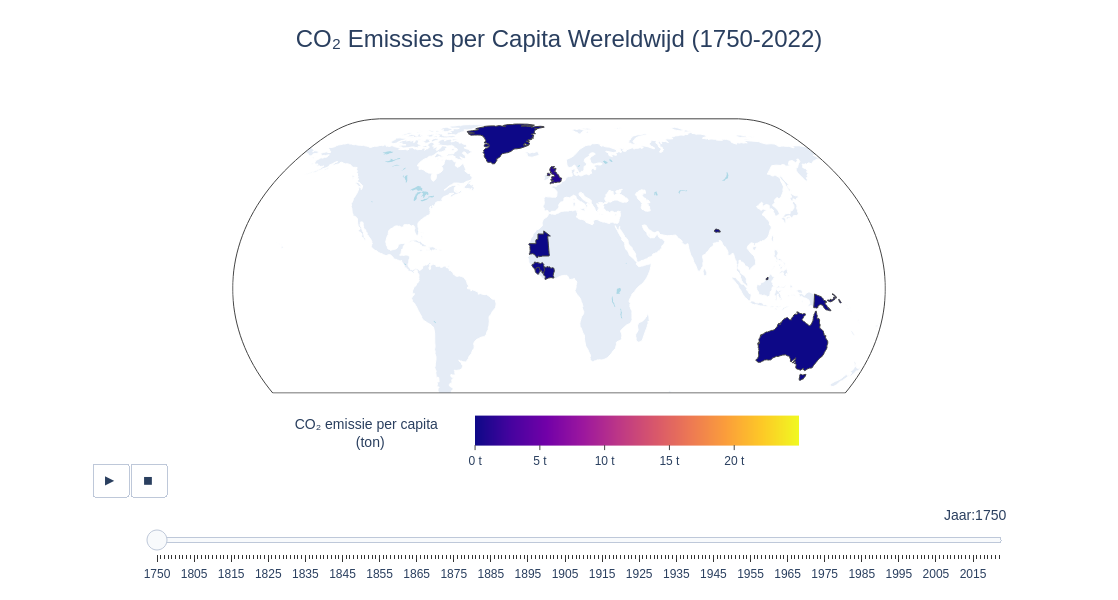

In [8]:
import plotly.express as px
import pandas as pd

# Veronderstelling dat je de dataset correct hebt ingelezen als df_co2_per_capita_cleaned

# Zorg ervoor dat de jaren gesorteerd zijn
df_co2_per_capita_cleaned = df_co2_per_capita_cleaned.sort_values(by='Year')

# Maak de kaart met een slider voor de jaren
fig = px.choropleth(
    df_co2_per_capita_cleaned, 
    locations="Code", 
    color="Annual CO₂ emissions (per capita)", 
    hover_name="Entity", 
    animation_frame="Year",
    color_continuous_scale=px.colors.sequential.Plasma,  # Aangepaste kleurenschaal
    range_color=(0, 25),
    labels={'Annual CO₂ emissions (per capita)': 'CO₂ emissies per capita (ton)'},
    title='CO₂ emissie per capita wereldwijd'
)

# Aanpassingen aan de layout
fig.update_layout(
    geo=dict(
        showframe=True,
        showcoastlines=True,
        coastlinecolor="white",
        projection_type='natural earth',
        lakecolor="lightblue"
    ),
    width=800,  # Vergroot de breedte van de kaart
    height=600,  # Vergroot de hoogte van de kaart
    title={
        'text': "CO₂ Emissies per Capita Wereldwijd (1750-2022)",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}  # Grotere titel
    },
    coloraxis_colorbar=dict(
        title="CO₂ emissie per capita <br> (ton)",
        thicknessmode="pixels",
        thickness=30,
        lenmode="pixels",
        len=500,  # Langer maken van de colorbar
        orientation='h',  # Horizontale colorbar
        xanchor='center',
        x=0.5,
        y=-0.3,  # Plaatsing tussen slider en kaart
        ticks="outside",
        tickvals= [0, 5, 10, 15, 20], # Gebruik visueel gelijk verdeelde tickvals
        ticktext=["0 t", "5 t", "10 t", "15 t", "20 t"]  # De daadwerkelijke waarden
    )
)

fig.update_geos(
    lakecolor="lightblue",
    showcountries=False,
    countrycolor="black",
    coastlinecolor="white",
    lataxis_range=[-50, 90]  # Dit beperkt de zuidelijke breedtegraad tot -50
)

# Hover-data aanpassen
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>" +
                  "Jaar: %{frame}<br>" +
                  "CO₂ emissies per capita: %{z:.2f} ton<br>" +
                  "<extra></extra>"
)

# Unieke jaren verkrijgen voor de slider stappen
unique_years = df_co2_per_capita_cleaned['Year'].unique()
unique_years.sort()  # Zorg ervoor dat de jaren gesorteerd zijn

# Aangepaste slider
fig.update_layout(
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 14},
            'prefix': 'Jaar:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'linear'},  # Langzamer bewegen door jaren
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.07,
        'y': -0.2,  # Plaatsing van de slider lager om overlap te voorkomen
        'steps': [{
            'args': [[str(year)], {'frame': {'duration': 300, 'redraw': True},
                                   'mode': 'immediate',
                                   'transition': {'duration': 300}}],
            'label': str(year),
            'method': 'animate'
        } for year in unique_years]
    }]
)

# Toon de kaart
fig.show()

